# Jan 17th, 2022 (Results at various thresholds, discussion on topology)

**Motivation**: First, I show that Network Portrait Divergence uncovers nontrivial dependence of network topologies to sparsification thresholds. I also compare memberships for runs that have $K = 4$ communinities, but at different thresholds of $\{0.10, 0.15, 0.20\}$.  I conclude that they are not significantly different. Next, I propose how we go about this in the first 2 papers.  Finally, I discuss what I will be doing immediately to finish paper # 1 asap.  <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


from analysis.portrait import *
from sklearn.manifold import TSNE, MDS


def _mk_div_plot(df_within, df_table, best_i, best_d, offset: int = 0, show=True):
    fig, axes = create_figure(1, 2, (13.5, 4.6), gridspec_kw={'width_ratios': [1, 2.7]})

    sns.lineplot(
        data=df_within,
        x='density',
        y='val',
        hue='subject',
        palette='muted',
        ax=axes[0],
    )
    axes[0].set_xlabel('Density', fontsize=15)
    axes[0].set_ylabel('Avg Div', fontsize=15)
    axes[0].tick_params(axis='y', labelsize=13)
    axes[0].set_title(f"individuals", fontsize=15, y=1.01)

    best_indiv = df_table.values[:, offset:].argmin(1) + offset
    min_x, min_y = list(zip(*enumerate(best_indiv)))
    min_x = [e + 0.5 for e in min_x]
    sns.heatmap(data=df_table, cmap='Spectral_r', ax=axes[1])
    axes[1].scatter(min_y, min_x, color='k', s=100, marker='x')
    axes[1].axvline(best_i, color='k', ls='--')

    xticklabels = axes[1].get_xticklabels()
    _ = [
        t.set_text(f"{np.round(100 * float(t.get_text()), 1):0.1f}")
        for t in xticklabels
    ]
    axes[1].set_xticklabels(xticklabels)
    axes[1].set_xlabel('Density [%]', fontsize=15)
    axes[1].set_ylabel('Animal', fontsize=15)
    axes[1].tick_params(axis='y', labelsize=13)
    axes[1].set_title(f"group  .  .  .  best density = {best_d * 100:1.2f} % (dashed line)", fontsize=15, y=1.01)

    sup = fig.suptitle(f"mode = {mode}", fontsize=20, y=1.03)
    
    if show:
        plt.show()
    else:
        plt.close()
    
    return fig, sup

## Topological distances

### N = 128 columns / hemisphere

In [3]:
mice = Mice((128, 0, 100))

task = 'rest'
mice.setup_func_data(task)

In [4]:
# HIDE CODE


div_all, dfs_all = {}, {}
for mode in ['ca2', 'bold-lite', 'bold-ctx', 'bold']:
    proc, *_ = mice.get_data_containers(mode)
    dirs = {}
    for key in proc:
        sub, ses, run = mice.looper[key]
        if run == -1:
            continue
        net = Network(mice, key, mode, task)
        dirs[key] = net.create_save_dir()
    ids = mice.get_condition_ids(dirs)

    if mode in ['ca2', 'bold-lite']:
        densities = density_space(start=0.20, stop=0.02, num=100, log=True)
    else:
        densities = density_space(start=0.50, stop=0.02, num=100, log=True)
        
    portraits = {}
    for i, load_dir in enumerate(dirs.values()):
        load_file = pjoin(load_dir, 'portraits.npy')
        port = np.load(load_file, allow_pickle=True).item()
        portraits[i] = list(port.values())
        
    div = calculate_portrait_divergece_parallel(portraits, densities)
    dfs_all[mode] = prepare_divergence_dfs(div, densities, ids)
    div_all[mode] = div

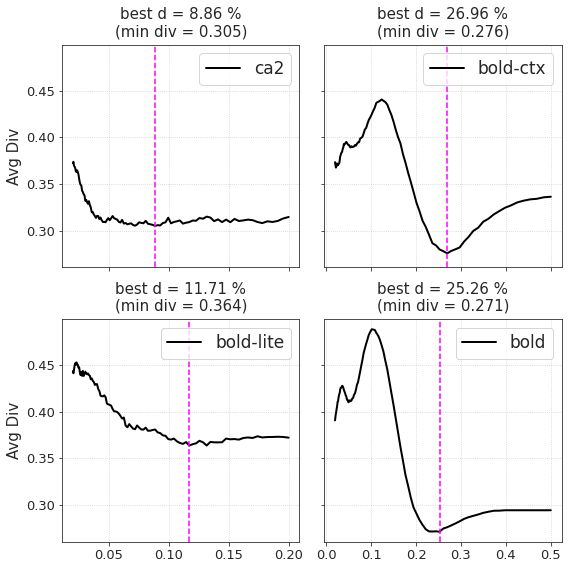

In [5]:
# HIDE CODE


fig, axes = create_figure(2, 2, (8, 8), sharex='col', sharey='all')
order = {0: 'ca2', 1: 'bold-ctx', 2: 'bold-lite', 3: 'bold'}
for i, mode in order.items():
    ax = axes.flat[i]
    dfs = dfs_all[mode]
    ax.plot(
        dfs['group_avg'].index, dfs['group_avg'].values,
        label=mode,
        color='k',
        lw=2,
    )
    ax.legend(fontsize=17)
    ax.axvline(dfs['best_d'], color='magenta', ls='--')
    ax.set_title(
        f"best d = {dfs['best_d'] * 100:1.2f} %\n(min div = {dfs['best_div']:0.3f})", fontsize=15, y=1.01)
    if i % 2 == 0:
        ax.set_ylabel("Avg Div", fontsize=15)
    ax.tick_params(axis='both', labelsize=13)
    ax.grid()
plt.show()

#### Group averaged

These figures show the how optimal graph densities depend on data modality, but also on the subset of ROIs that are included in the analysis.  Here I only report **"within session"** distances between pairs of runs from the same animal in the same session.

First, let me define what each of these terms mean:
- **ca2**: calcium data, obviously this only contains a subset of surface ROIs that appear in the 2D optical FOV
- **bold-lite**: this is bold data, using exactly the same ROIs as ca2 data
- **bold-ctx**: all cortical ROIs
- **bold**: all cortical and subcortical ROIs

We see that **ca2** and **bold-lite** show more or less the same behavior.  The average within session divergence plateaus starting from around $d = 0.1$ and stays that way up to $d=0.2$.  **bold-ctx** and **bold** also show similar behavior, but very different from the surface cases.  They have a much smoother curve which peaks at around $d=0.1$ and has a minimum at around $d\approx0.25$, then plataeus after that.

Why do **bold** and **bold-ctx** behave so differently compared to the other two?  For **bold-ctx**, we have included full cortical ROIs.  This means for each column, there are 3 ROIs at different depths. These ROIs from the same column are expected to be highly correlated.  The correlation patterns among these ROIs is also expected to be similar across animals.  Therefore, it is possible that we get a relatively higher optimal density, because it helps preserve this robust structure.  These links are likely always present, no matter which run or which animal.  Also, interestingly the average distance for this case is slightly smaller than surface-only case of **bold-lite**.

For  **bold** there is something similar going on.  Some subcortical regions are expected to have more uniform correlation patterns.  This is even more expected under anesthesia.  Now let us look at individuals rather than the group averaged case.

#### Individuals

If we look at density vs. topological distance plots for individuals, once again we see an interesting difference between **ca2** and **bold-lite** compared to **bold-ctx** and **bold**.  For the latter, the estimated optimal densities are a lot less variable across individuals compared to the surface-only cases.  This suggests that inclusion of all ROIs makes our estimates of the abstract interaction graphs more stable.

In figures below I use a cross mark (x) to show the optimal density for ech animal.  The dashed line shows group average.

------------------------------------------------------------------------------------------

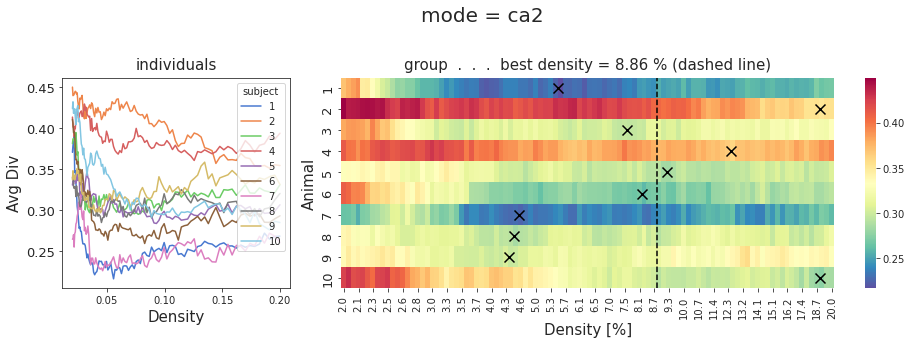

------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------

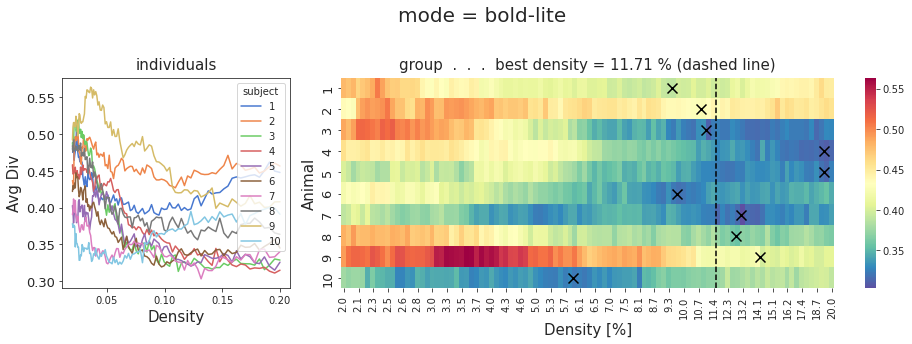

------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------

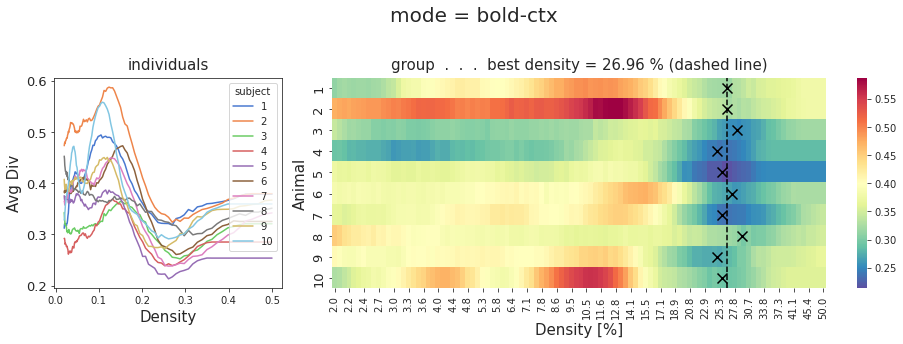

------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------

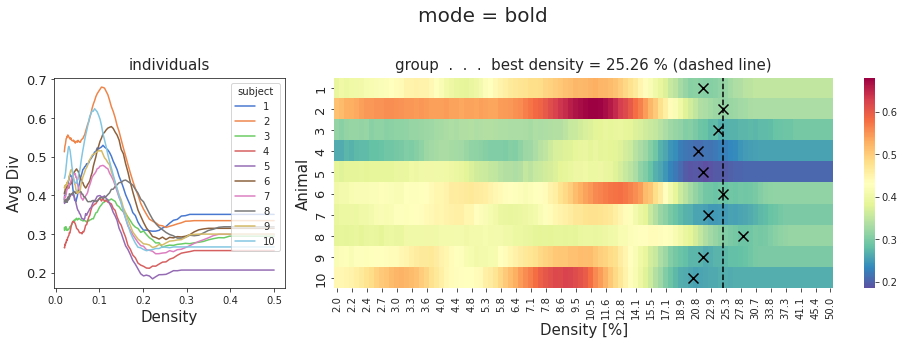

------------------------------------------------------------------------------------------

In [6]:
# HIDE CODE


for mode, dfs in dfs_all.items():
    print('-' * 90)
    _ = _mk_div_plot(
        df_within=dfs['within'],
        df_table=dfs['table'],
        best_i=dfs['best_i'],
        best_d=dfs['best_d'],
        offset=10 if mode == 'bold-ctx' else 0,
    )
    print('-' * 90)
    print('\n')

### What to do with this information?

I have the following proposal:

- For the first paper, we should only look at BOLD vs. Ca2+ one layer at a time.  That is, we first compare only surface ROIs.  Then we repeat the analysis for the next layer (depth) separately and so on.  Because of the aforementioned reasons, I’m expecting a fixed threshold of $d=0.1$ or $0.2$ or anything in between will work fine for all of these cases.

- For the next paper, we go all the way and include every cortical and subcortical regions.  As an important result of this paper, we introduce the topological distance method as a reliable and principled way of choosing hyperparameters.

- We can define a statistically precise model and test a few more things to turn this into a strong result.  We can possibly call it **longitudinal consistency** or something like that, if we decided to rely on the fact that we have several sessions in our recordings.  Here I haven't relied on this and only focused on within session distances, but having multiple sessions is a resource we can (and should) exploint.

- The first paper is already loaded with many results, and topology would only confuse the reviewers and make the paper cumbersome to read.  Luckily, for this paper any density $d \in [0.1, 0.2]$ is going to work just fine (I provide more evidence below by comparing membership values for different densities).

- For the next paper, inclusion of discussion on topology and thresholding in a principled way becomes necessary due to the fact that for one network (ca2) the "typical" choice of $d\approx0.1$ is optimal but for the other (bold) this is almost exactly the worst choice.

- I believe this would be relatively quick since I already have a lot of results ready to go.

For the 2nd paper there are two major TODO items that I can think of now:

1. First task is choosing subcortical regions carefully.  We have to decide which regions to include for each run based on tSNR. This should be relatively quick, as most of the script for this purpose is already written and reaady.  Just needs some modifications + coming up with appropriate criteria to make decisions.

2. Next, we need to provide more evidence that the topological distance thing is working.  The fact that it is capturing some nontrivial density vs. topo distance structure is interesting.  It could very well have been a flat or random looking curve, but it's not.  People need to know about this.  What I need is a good, rigorous statistical model to strengthen the results, for which I can use some help.  I think we can define an ANOVA based model inspired by how it is done in test-retest reliability work?  In any case, I would be happy with any logical decision that we make here as I don't have strong opinions on this aspect of the work.

### N = 256 columns / hemisphere

Before moving on to the next section I make the same plots for a parcellation with different # ROIs for bookkeeping purposes.

In [7]:
mice = Mice((256, 0, 100))

task = 'rest'
mice.setup_func_data(task)

In [8]:
# HIDE CODE


div_all, dfs_all = {}, {}
for mode in ['ca2', 'bold-lite', 'bold-ctx', 'bold']:
    proc, *_ = mice.get_data_containers(mode)
    dirs = {}
    for key in proc:
        sub, ses, run = mice.looper[key]
        if run == -1:
            continue
        net = Network(mice, key, mode, task)
        dirs[key] = net.create_save_dir()
    ids = mice.get_condition_ids(dirs)

    if mode in ['ca2', 'bold-lite']:
        densities = density_space(start=0.20, stop=0.02, num=100, log=True)
    else:
        densities = density_space(start=0.50, stop=0.02, num=100, log=True)
        
    portraits = {}
    for i, load_dir in enumerate(dirs.values()):
        load_file = pjoin(load_dir, 'portraits.npy')
        port = np.load(load_file, allow_pickle=True).item()
        portraits[i] = list(port.values())
        
    div = calculate_portrait_divergece_parallel(portraits, densities)
    dfs_all[mode] = prepare_divergence_dfs(div, densities, ids)
    div_all[mode] = div

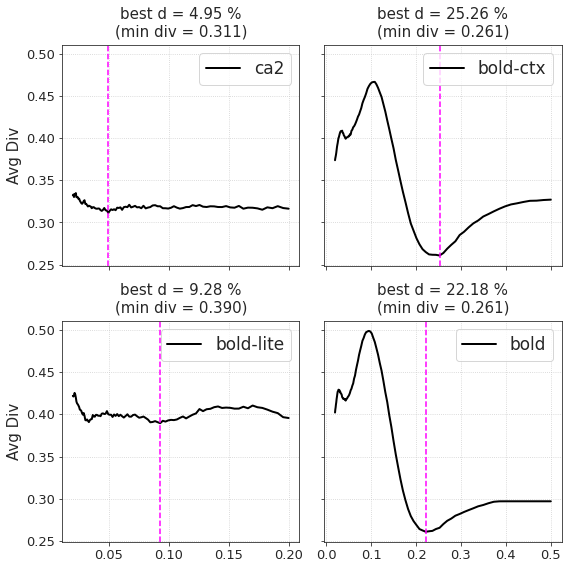

In [9]:
# HIDE CODE


fig, axes = create_figure(2, 2, (8, 8), sharex='col', sharey='all')
order = {0: 'ca2', 1: 'bold-ctx', 2: 'bold-lite', 3: 'bold'}
for i, mode in order.items():
    ax = axes.flat[i]
    dfs = dfs_all[mode]
    ax.plot(
        dfs['group_avg'].index, dfs['group_avg'].values,
        label=mode,
        color='k',
        lw=2,
    )
    ax.legend(fontsize=17)
    ax.axvline(dfs['best_d'], color='magenta', ls='--')
    ax.set_title(
        f"best d = {dfs['best_d'] * 100:1.2f} %\n(min div = {dfs['best_div']:0.3f})", fontsize=15, y=1.01)
    if i % 2 == 0:
        ax.set_ylabel("Avg Div", fontsize=15)
    ax.tick_params(axis='both', labelsize=13)
    ax.grid()
plt.show()

------------------------------------------------------------------------------------------

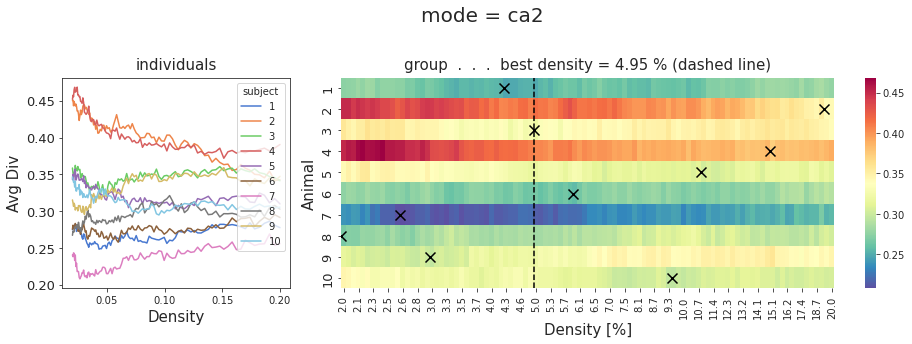

------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------

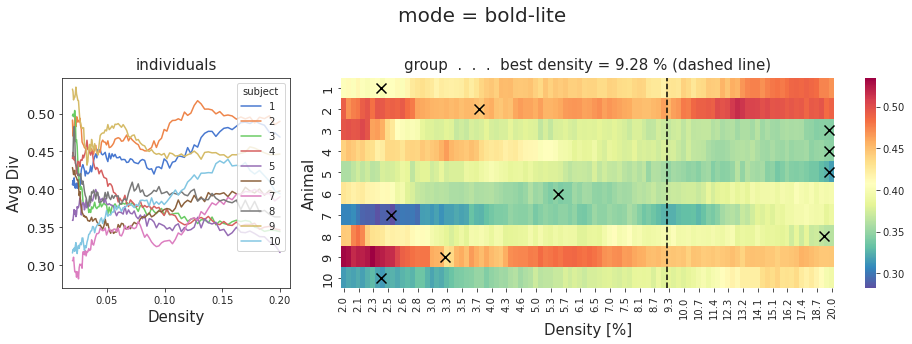

------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------

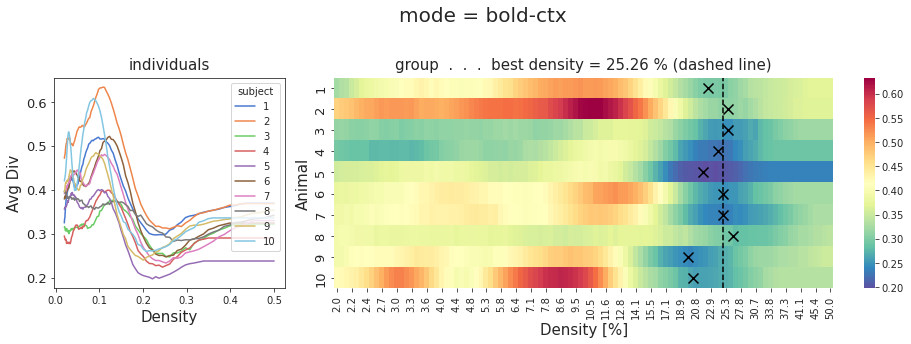

------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------

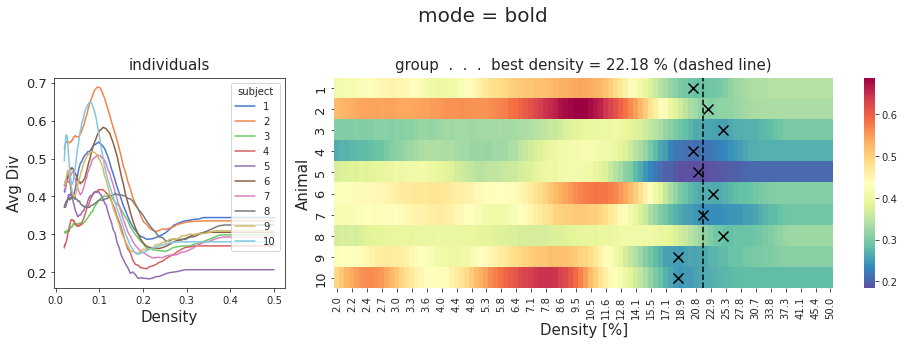

------------------------------------------------------------------------------------------

In [10]:
# HIDE CODE


for mode, dfs in dfs_all.items():
    print('-' * 90)
    _ = _mk_div_plot(
        df_within=dfs['within'],
        df_table=dfs['table'],
        best_i=dfs['best_i'],
        best_d=dfs['best_d'],
        offset=0,#10 if mode == 'bold-ctx' else 0,
    )
    print('-' * 90)
    print('\n')

We see that at least for the first paper (Ca2+ and BOLD-Lite only), the choise of $N = 256$ columns is probably not a good idea as it increases the average minimum divregence.  This shows the utility of topological distane approach in choosing other hyperparams such as # ROIs and so on.

## Results at $d = 0.10, 0.15,$ and $0.20$

In [11]:
mice = Mice((128, 0, 100))

In [12]:
props_base = {
    'num_k': 4,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'verbose': False,
}
bins = np.linspace(0.2, 1.0, 5)
statistic = mk_statistic_fn(bins, False)

In [13]:
# HIDE CODE


pis_ca, pis_bold = {}, {}
projs_ca, projs_bold = {}, {}
for p in [10, 15, 20]:
    props_ca = {'perc': f"p{p}-sample", **props_base}
    props_bold = {'perc': f"p{p}-sample", **props_base}
    
    # Group results
    gr_ca = Group(mode='ca2', centroids_from='runs', **props_ca)
    group_ca = gr_ca.fit_group(skip_align=False)

    gr_bold = Group(mode='bold-lite', centroids_from='runs', **props_bold)
    group_bold = gr_bold.fit_group(skip_align=False)

    output_ca = statistic(group_ca['gam_run'])
    output_bold = statistic(group_bold['gam_run'])
    
    if p == 10:
        output_bold['pi_avg'] = output_bold['pi_avg'][[0, 3, 2, 1]]

    gr_ca.pi = output_ca['pi_avg']
    gr_bold.pi = output_bold['pi_avg']

    # Proj
    proj_ca = gr_ca.project_vec()
    proj_bold = gr_bold.project_vec()
    
    # save
    pis_ca[p] = output_ca['pi_avg']
    pis_bold[p] = output_bold['pi_avg']
    projs_ca[p] = proj_ca
    projs_bold[p] = proj_bold

### BOLD-Lite

#### d = 0.1 vs d = 0.15

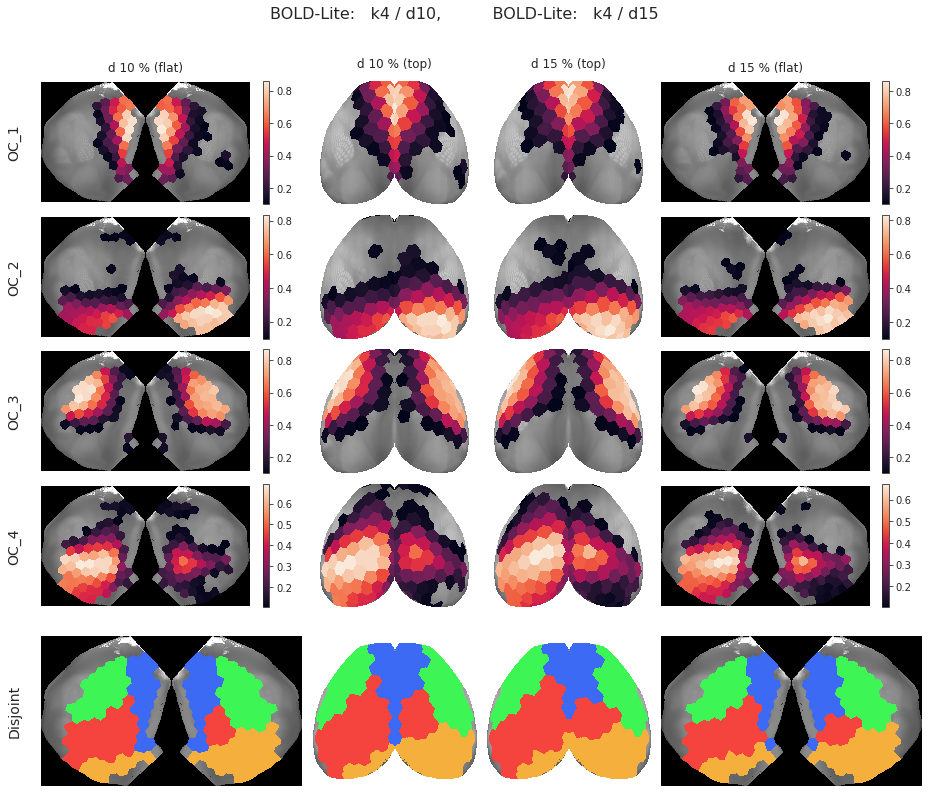

In [14]:
# HIDE CODE


p1, p2 = 10, 15

fig, _ = gr_bold.show(
    projs_bold[p1], projs_bold[p2],
    labels=(f"d {p1} %", f"d {p2} %"),
    cmaps=('rocket',) * 2,
    display=False,
)
sup = f"BOLD-Lite:   k{props_base.get('num_k')} / d{p1},          "
sup += f"BOLD-Lite:   k{props_base.get('num_k')} / d{p2}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

#### d = 0.1 vs d = 0.20

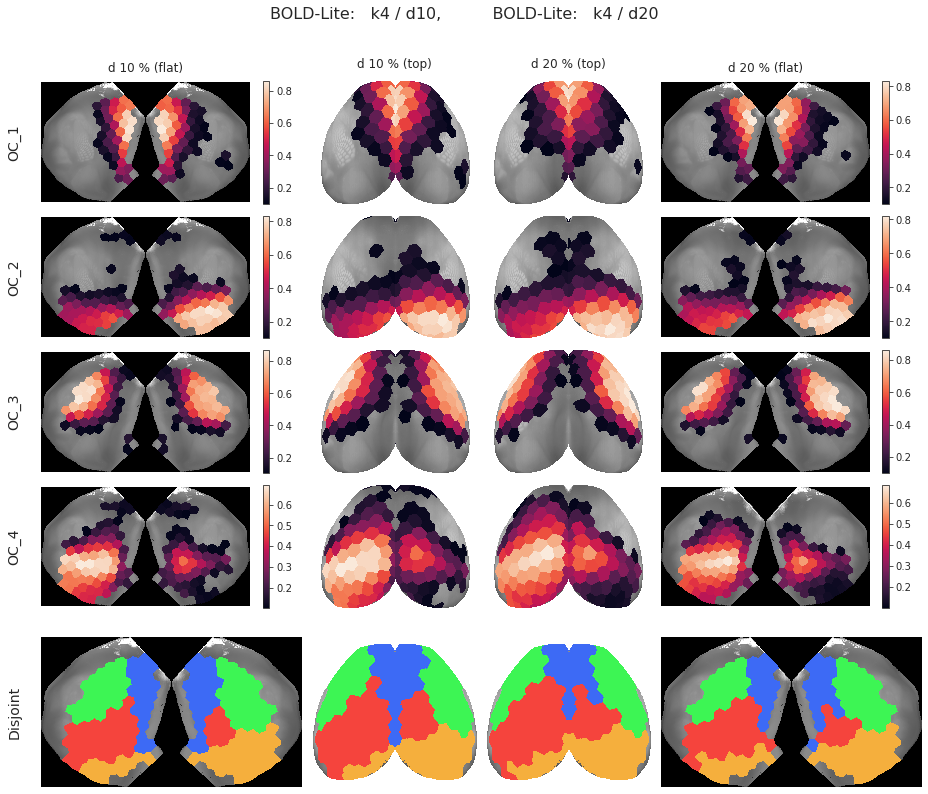

In [15]:
# HIDE CODE


p1, p2 = 10, 20

fig, _ = gr_bold.show(
    projs_bold[p1], projs_bold[p2],
    labels=(f"d {p1} %", f"d {p2} %"),
    cmaps=('rocket',) * 2,
    display=False,
)
sup = f"BOLD-Lite:   k{props_base.get('num_k')} / d{p1},          "
sup += f"BOLD-Lite:   k{props_base.get('num_k')} / d{p2}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

### Ca$^{2+}$

#### d = 0.1 vs d = 0.15

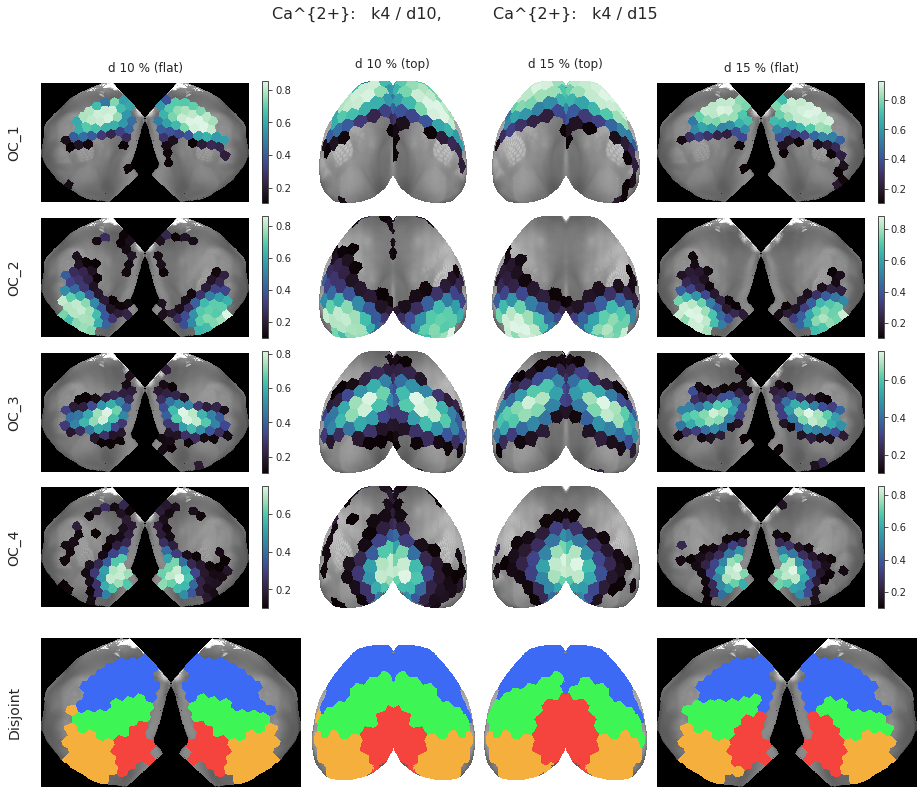

In [16]:
# HIDE CODE


p1, p2 = 10, 15

fig, _ = gr_bold.show(
    projs_ca[p1], projs_ca[p2],
    labels=(f"d {p1} %", f"d {p2} %"),
    cmaps=('mako',) * 2,
    display=False,
)
sup = r"Ca^{2+}:   " + f"k{props_base.get('num_k')} / d{p1},          "
sup += r"Ca^{2+}:   " + f"k{props_base.get('num_k')} / d{p2}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

#### d = 0.1 vs d = 0.2

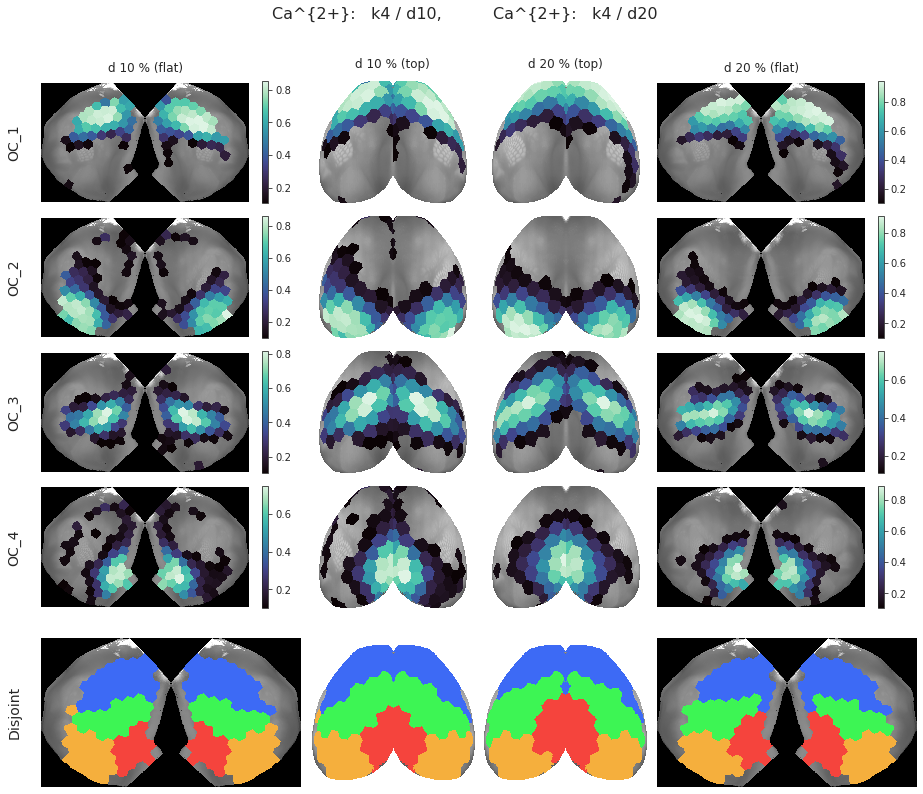

In [17]:
# HIDE CODE


p1, p2 = 10, 20

fig, _ = gr_bold.show(
    projs_ca[p1], projs_ca[p2],
    labels=(f"d {p1} %", f"d {p2} %"),
    cmaps=('mako',) * 2,
    display=False,
)
sup = r"Ca^{2+}:   " + f"k{props_base.get('num_k')} / d{p1},          "
sup += r"Ca^{2+}:   " + f"k{props_base.get('num_k')} / d{p2}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

### Cosine similarity

In [18]:
# HIDE CODE


sim_mat = np.zeros((3, 3))
for i, j in itertools.combinations(range(3), 2):
    s = dist2sim(sp_dist.cdist(
        XA=list(pis_bold.values())[i],
        XB=list(pis_bold.values())[j],
        metric='cosine',
    ))
    sim_mat[i, j] = np.diag(s).mean()
    
    s = dist2sim(sp_dist.cdist(
        XA=list(pis_ca.values())[i],
        XB=list(pis_ca.values())[j],
        metric='cosine',
    ))
    sim_mat[j, i] = np.diag(s).mean()

sim_mat

array([[0.        , 0.99345837, 0.98846437],
       [0.97635108, 0.        , 0.99760692],
       [0.96353602, 0.99593789, 0.        ]])

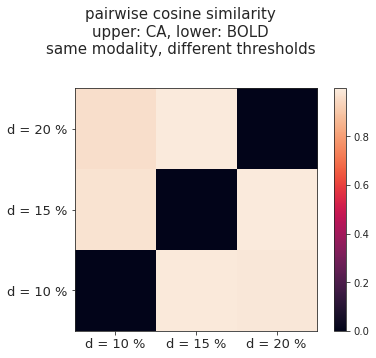

In [19]:
# HIDE CODE


fig, ax = create_figure(figsize=(6, 5))
im = ax.imshow(sim_mat)
plt.colorbar(im, ax=ax)

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['d = 10 %', 'd = 15 %', 'd = 20 %'])
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(['d = 10 %', 'd = 15 %', 'd = 20 %'])
ax.invert_yaxis()

ax.tick_params(axis='both', labelsize=13)
fig.suptitle("pairwise cosine similarity\nupper: CA, lower: BOLD\nsame modality, different thresholds\n", fontsize=15)
plt.show()

In [20]:
# HIDE CODE


sim_ca = sim_mat[np.tril_indices(3, k=-1)].mean()
sim_bold = sim_mat[np.triu_indices(3, k=1)].mean()

msg = "avg cosine similarity across different thresholds:\n"
msg += f"BOLD-Lite:  {sim_bold:0.3f}\t/\t"
msg += f"CA:  {sim_ca:0.3f}"
print(msg)

avg cosine similarity across different thresholds:
BOLD-Lite:  0.993       /       CA:  0.979

In [21]:
# HIDE CODE


sim_mat = np.zeros((3, 3))
for i, j in itertools.combinations(range(3), 2):
    s = dist2sim(sp_dist.cdist(
        XA=list(pis_bold.values())[i],
        XB=list(pis_ca.values())[j],
        metric='cosine',
    ))
    sim_mat[i, j] = np.diag(s).mean()
    
for i in range(3):
    s = dist2sim(sp_dist.cdist(
        XA=list(pis_bold.values())[i],
        XB=list(pis_ca.values())[i],
        metric='cosine',
    ))
    sim_mat[i, i] = np.diag(s).mean()

sim_mat

array([[0.67469531, 0.72545984, 0.73775235],
       [0.        , 0.75063037, 0.76380168],
       [0.        , 0.        , 0.7648774 ]])

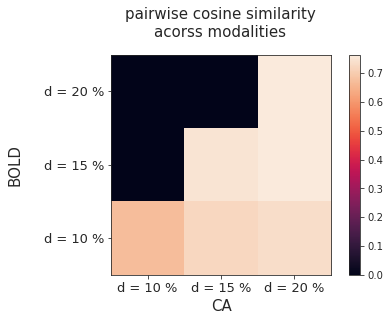

In [22]:
# HIDE CODE


fig, ax = create_figure(figsize=(6.3, 4.5))
im = ax.imshow(sim_mat)
plt.colorbar(im, ax=ax)

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['d = 10 %', 'd = 15 %', 'd = 20 %'])
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(['d = 10 %', 'd = 15 %', 'd = 20 %'])
ax.invert_yaxis()

ax.set_ylabel('BOLD\n', fontsize=15)
ax.set_xlabel('CA', fontsize=15)

ax.tick_params(axis='both', labelsize=13)
fig.suptitle("pairwise cosine similarity\nacorss modalities", x=0.57, fontsize=15)
plt.show()

## Conclusion

- Inferring things from data depend on choices we make. 
    - For example, these choices include # ROIs, edge filtering approach, and the threshold chosen.
    - Sometimes we are lucky and we make random but decent choices. Other times we may not be so lucky.
- I showed that for the case where we include ROIs from the full brain, the choice of graphs densities matters a lot.
- Fortunately, for surface ROIs this doesn't matter much.
    - Evidence # 1: density vs. mean divergence plateaus in the range $d \in [0.1, 0.2]$.
    - Evidence # 2: membership distributions are almost exactly identical for the 3 thresholds in that range.
- Therfore, we can rest assured that $d = 0.1$ or $0.2$ will work fine for the main results in the first paper.
    - Ideally we would include results for other thresholds in supplementary to show that our claims don't depend strongly on the threshold.
- For the next paper, we can discuss the necessaty of choosing hyperparameters in a more principled way if you want results that are not completely untrustworthy, thus leadng by example.
- Then we can analyze full brain BOLD vs Ca$^{2+}$ knowing that our inferences are not distorted because of our random choices -- to the best of our knowledge...
- I've already seen some interesting structure in the membership values and embedded gradients of subcotrical areas.  I'm expecting things to only improve from here on.

## What next

The following is a tentative list of things to do next:

1. Revise Figure 1 writeup, use parsimonious but informative sentences and fill in the gaps.
2. Produce material for Figure 2 and write another PDF also with method.
3. Start writing the main content of the paper, but only bullet points.  This, along with figure writeups will help shape the skeleton.

> **Data on its way:** Gabe just sent an email to Eve and me that the data is resampled to 0.2mm and is ready to share.  I will finally receive the cleaned up data soon after Gabe gets his account.  After that, I will produce semi-final figs and include them in PDF writeups with the relevant methods.